In [90]:
import numpy as np
import pandas as pd
import random

In [91]:
df=pd.read_csv('data/selected.csv')
print(df.head())

    Nom Ville         MAJ      Code Postal    Code INSEE   Code Région  \
0       Machy       MACHY             10320         10212           21   
1   Gueschart   GUESCHART             80150         80396           11   
2      Bonloc      BONLOC             64240         64134           72   
3     Quillan     QUILLAN             11500         11304           91   
4    Courmont    COURMONT             70400         70182           72   

    Latitude    Longitude    Eloignement   
0   48.133333     4.050000           1.19  
1   50.233333     2.000000           2.18  
2   43.366667    -1.266667           1.76  
3   42.866667     2.183333           1.72  
4   47.616667     6.633333           1.91  


In [92]:
# Nombre de villes
num_cities = len(df)

In [93]:
# Fonction pour calculer la distance en kilomètres entre deux villes
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0  # Rayon moyen de la Terre en kilomètres

    # Conversion des latitudes et longitudes de degrés en radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    # Différences entre les latitudes et longitudes
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Formule de Haversine
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Distance en kilomètres
    distance = R * c
    return distance

In [94]:
# Construire la matrice de distances à partir des coordonnées en utilisant la fonction haversine_distance
distances = np.zeros((num_cities, num_cities))
for i in range(num_cities):
    for j in range(num_cities):
        distances[i, j] = haversine_distance(df.iloc[i][' Latitude '], df.iloc[i][' Longitude '],
                                             df.iloc[j][' Latitude '], df.iloc[j][' Longitude '])


In [95]:
# Paramètre de température (à ajuster)
temperature = 1.0
# Nombre d'itérations MCMC (à ajuster)
N = 10000



In [96]:
# Initialiser un chemin aléatoire
current_path = np.random.permutation(num_cities)


In [97]:
# Fonction pour calculer la distance totale d'un chemin
def total_distance(path, distances):
    total_dist = 0
    num_cities = len(path)
    for i in range(num_cities):
        total_dist += distances[path[i], path[(i + 1) % num_cities]]
    return total_dist

In [101]:
'''Initialiser X = x0
n = 0
Repéter jusqu à n = N `
{ i = X
Choisir j avec probabiliteé qi,j
ρ = π(j)qj,i / π(i)qi,j
If (ρ ≥ 1) then { X = j }
else { Choisir U uniforme sur [0, 1]
If (U < ρ) then { X = j } }
n = n+1
}
X
'''

'''σ et σ’ sont voisins si en permutant 2 villes on passe de σ à σ’
chaque chemin σ a m(m-1)/2 voisins

alors
qσ,σ’= 2/m(m-1) si σ,σ’ sont voisins sinon 0
Propriétés: qσ,σ’>0 ⇔ qσ’,σ > 0 ; Q irréductible et Q est 2-périodique

Algo:

Q=(qσ,σ’) avec σ,σ’ appartient à E
Répeter N fois
	X <- σ
	Choisir σ’ (voisin de σ) avec proba qσ,σ’= 2/m(m-1) si σ,σ’ sont voisins sinon 0
	rho=pi(σ’)qσ’,σ/pi(σ)qσ,σ’ = exp((1/T)*H(σ)-H(σ’)
		si rho>=1, pσ,σ’=pσ’,σ : X<-σ’
		si rho <1 avec proba p X<-σ’ si avec proba 1-p : Rien'''
# Normalisation des distances
max_distance = np.max(distances)
distances_normalized = distances / max_distance

# Algorithme MCMC
for _ in range(N):
    # Copier le chemin courant
    new_path = current_path.copy()
    
    # Choisir deux indices différents aléatoirement
    idx1, idx2 = np.random.choice(num_cities, 2, replace=False)
    
    # Permuter les villes aux indices choisis
    new_path[idx1], new_path[idx2] = new_path[idx2], new_path[idx1]

    # Calculer la différence de distances normalisées
    delta_distance = (total_distance(current_path, distances_normalized) - total_distance(new_path, distances_normalized))
    
    
    # Calculer les probabilités de transition
    q_current_new = 2 / (num_cities * (num_cities - 1))
    q_new_current = 2 / (num_cities * (num_cities - 1))
    
    # Calculer le rapport de probabilité
    rho = np.exp((1 / temperature) * (total_distance(current_path, distances) - total_distance(new_path, distances)))
    
    # Mettre à jour le chemin avec une certaine probabilité
    if rho >= 1 or random.random() < rho:
        current_path = new_path

# Afficher le chemin et la distance totale
print("Chemin optimal:", current_path)
print("Distance minimale:", total_distance(current_path, distances))

Chemin optimal: [37  2 16 28 15 13 27 34  0 21 19 12 24 23 17 30 35 22 11  3 32 20 25 18
  6 31  9  1 26  5 14 29 33  7 36 39  8  4 10 38]
Distance minimale: 6141.73261209805


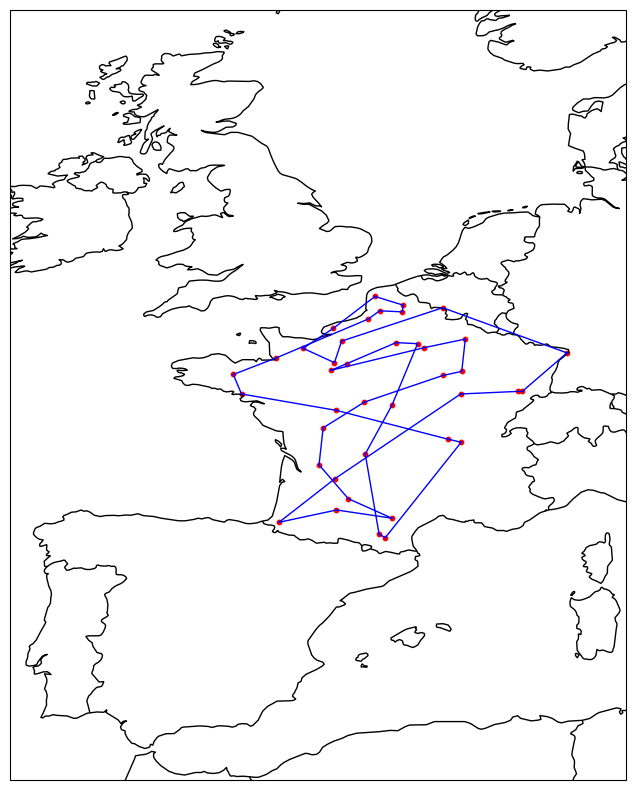

In [99]:
# Afficher le meilleur chemin sur la carte
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Créer une carte
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-10, 10, 35, 60], crs=ccrs.PlateCarree())


# Ajouter les frontières des pays
ax.add_feature(cfeature.BORDERS)


# Ajouter les côtes
ax.add_feature(cfeature.COASTLINE)


# Ajouter les villes
plt.scatter(df[' Longitude '], df[' Latitude '], color='red', s=10, transform=ccrs.PlateCarree())


# Ajouter le chemin indiqué par les indices des villes dans le meilleur chemin
for i in range(num_cities):
    plt.plot([df.iloc[current_path[i]][' Longitude '], df.iloc[current_path[(i + 1) % num_cities]][' Longitude ']],
             [df.iloc[current_path[i]][' Latitude '], df.iloc[current_path[(i + 1) % num_cities]][' Latitude ']],
             color='blue', linewidth=1, transform=ccrs.PlateCarree())

plt.show()

